In [53]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras

2023-04-12 16:28:27.310978: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def loadCombinedArray(cases,field):
    data = np.concatenate([np.load('../data/'+dataset+'/'+dataset+'_'+case+'_'+field + '.npy') for case in cases])
    return data


In [3]:
dataset = "kepsilon"
cases   = ["PHLL_case_1p0"]

In [17]:
x  = loadCombinedArray(cases,"Cx")
y  = loadCombinedArray(cases,"Cy")
z  = loadCombinedArray(cases,"Cz")
Ux = loadCombinedArray(cases,"Ux")
Uy = loadCombinedArray(cases,"Uy")
Uz = loadCombinedArray(cases,"Uz")
p  = loadCombinedArray(cases,"p")


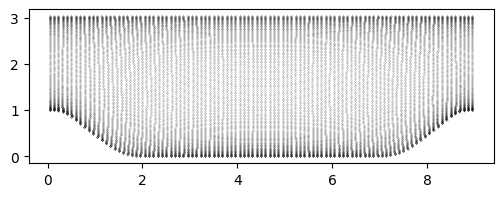

In [13]:
fig, ax = plt.subplots(figsize=(6,2))

ax.scatter(x,y,c="k",s=0.01)

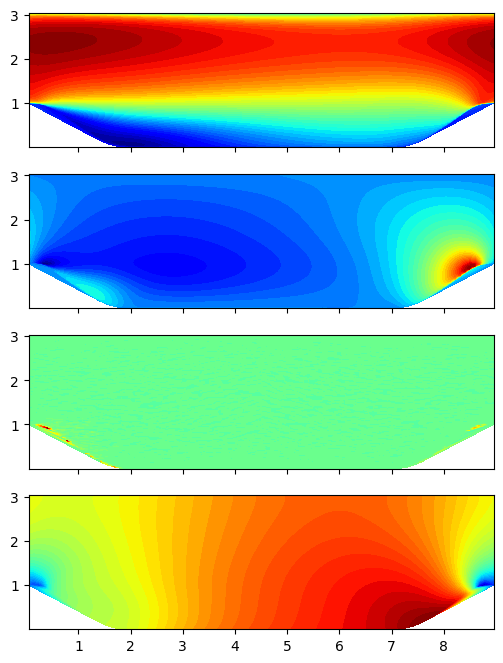

In [29]:
fig, ax = plt.subplots(4,figsize=(6,8),sharex=True)

ax[0].tricontourf(x,y,Ux,levels=50,cmap="jet")
ax[1].tricontourf(x,y,Uy,levels=50,cmap="jet")
ax[2].tricontourf(x,y,Uz,levels=50,cmap="jet")
ax[3].tricontourf(x,y,p, levels=50,cmap="jet")

                 Ux            Uy            Uz             p
count  14751.000000  14751.000000  1.475100e+04  14751.000000
mean       0.017065      0.000233  3.940499e-23     -0.000078
std        0.010318      0.001877  2.724152e-20      0.000074
min       -0.003587     -0.003892 -8.116420e-19     -0.000439
25%        0.007466     -0.000656 -3.820135e-23     -0.000126
50%        0.019827     -0.000055  0.000000e+00     -0.000066
75%        0.026507      0.000416  4.274895e-23     -0.000028
max        0.030797      0.011531  9.433190e-19      0.000059


array([[<AxesSubplot:title={'center':'Ux'}>,
        <AxesSubplot:title={'center':'Uy'}>],
       [<AxesSubplot:title={'center':'Uz'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

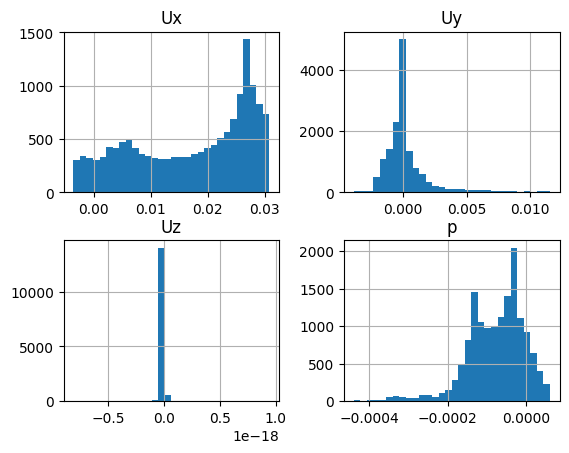

In [35]:
# get data ready in an array
# scale the data
# be clear what are the features (X) , and what are target (Y)
# X[Ux,Uy,Uz], Y[p]
data_combined = np.column_stack((Ux,Uy,Uz,p))
df = pd.DataFrame(data=data_combined)
df.columns=["Ux","Uy","Uz","p"]
print(df.describe())
df.hist(bins=30)

In [44]:
df_features = df[["Ux","Uy"]]
df_target   = df["p"]

scaler_features = preprocessing.MinMaxScaler()
scaler_target   = preprocessing.MinMaxScaler()

df_features = pd.DataFrame(scaler_features.fit_transform(df_features),
                          columns=["Ux","Uy"])
df_target = pd.DataFrame(scaler_target.fit_transform(df_target.values.reshape(-1,1)),
                          columns=["p"])

In [57]:
# df_features

In [61]:
# Building my NN
keras.backend.clear_session()

#Ux, Uy
input_layer = keras.layers.Input(shape=(2),name="input_layer")

#Hidden layers
hidden1     = keras.layers.Dense(20,name="Hidden1",kernel_initializer="lecun_normal",
                                activation="selu")(input_layer)
hidden2 = keras.layers.Dense(20,name='Hidden2', kernel_initializer="lecun_normal", activation = "selu")(hidden1)
hidden3 = keras.layers.Dense(20,name='Hidden3', kernel_initializer="lecun_normal", activation = "selu")(hidden2)
hidden4 = keras.layers.Dense(20,name='Hidden4', kernel_initializer="lecun_normal", activation = "selu")(hidden3)
hidden5 = keras.layers.Dense(20,name='Hidden5', kernel_initializer="lecun_normal", activation = "selu")(hidden4)


output_layer = keras.layers.Dense(1,name="output_layer")(hidden5)

model=keras.Model(inputs=[input_layer], outputs=[output_layer])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 Hidden1 (Dense)             (None, 20)                60        
                                                                 
 Hidden2 (Dense)             (None, 20)                420       
                                                                 
 Hidden3 (Dense)             (None, 20)                420       
                                                                 
 Hidden4 (Dense)             (None, 20)                420       
                                                                 
 Hidden5 (Dense)             (None, 20)                420       
                                                                 
 output_layer (Dense)        (None, 1)                 21    

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(optimizer,loss="mse",metrics=["mae","mse"])

In [67]:
history = model.fit([df_features],df_target,
                    epochs=200,
                    verbose= 0,
)

461/461 [==============================] - 0s 971us/step


Text(0.5, 1.0, 'Truth')

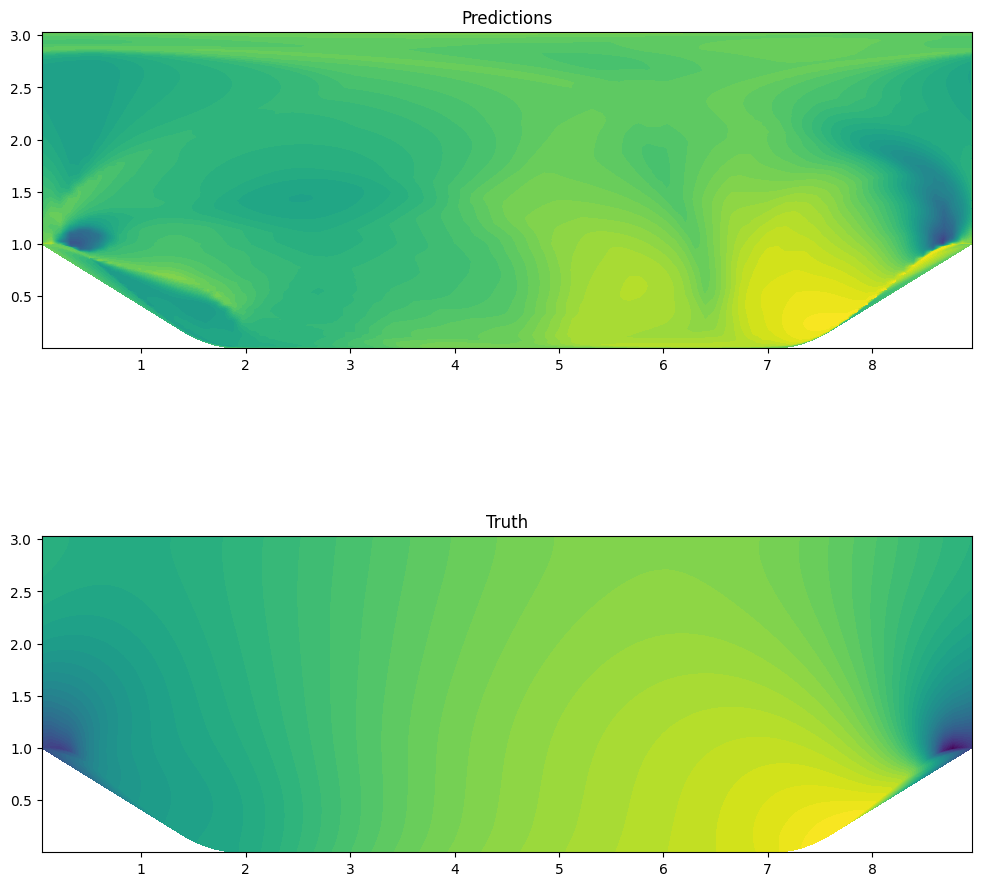

In [68]:
predictions = model.predict(df_features).reshape(len(df_features))
truth = df_target['p']

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.tricontourf(x,y,predictions,levels=50,vmin=0,vmax=1)
ax1.set_aspect(1)
ax1.set_title('Predictions')
ax2.tricontourf(x,y,truth,levels=50,vmin=0,vmax=1)
ax2.set_aspect(1)
ax2.set_title('Truth')